In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

In [3]:
from pyDOE import *

Text(0,0.5,u'$y$')

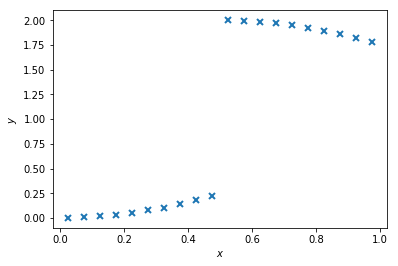

In [4]:
dim = 1
n = 20
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]
Xnorm = (X - 0.5) / 0.5
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [5]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
noisekern = gpflow.kernels.RBF(input_dim=1, ARD=True)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(Xnorm, Y, k, nonstat, noisekern)

In [6]:
m.kerns["ell0"].variance.prior = gpflow.priors.Gamma(1., 1.)
m.kerns["ell0"].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# m.likelihood.variance = 0.01
# m.likelihood.variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)
m.noisekern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern2.variance.prior = gpflow.priors.Gamma(1., 1.)
#m.noisekern.variance = 1e-8
#m.noisekern.variance.fixed = True
m.noisekern.variance.prior = gpflow.priors.Gamma(.1, .1)

In [7]:
m.optimize(maxiter=500) # start near MAP

      fun: array([-21.5735159])
 hess_inv: <65x65 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.25124125e+02,   8.35943435e+01,  -2.10147115e+02,
        -1.17993053e+02,   6.57912021e+00,  -6.86813036e+00,
         2.47731585e+01,   1.13612503e+01,   1.39353961e+01,
        -2.11321797e+01,  -2.33970182e+00,   8.71429635e-01,
        -2.11729442e-01,   3.51972224e-01,   1.40164493e+00,
        -1.68134999e-01,   2.41992007e-01,   1.84727818e+00,
        -2.13453279e+00,   4.58362369e+00,   2.45900659e+01,
        -2.11723527e+00,   1.41177640e+00,   2.19988247e-01,
        -6.32379588e-03,  -1.47724965e-03,   7.05389966e-04,
         8.60954598e-03,  -1.01441651e-03,  -3.58434715e-03,
         2.27538744e-03,  -5.59470879e-04,   1.44030646e-03,
        -1.16379657e-03,   2.06756376e-03,   2.56241217e-04,
         3.81084813e-04,   3.91738085e-04,   4.84331177e-05,
        -9.84872665e-04,   1.50306290e+02,   2.70731560e+02,
        -3.75685639e+02,  -3.07148470e+02,   

In [8]:
samples = m.sample(500, verbose=True, epsilon=0.00005, thin = 2, burn = 100, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  90.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  92.0 %
Iteration:  200 	 Acc Rate:  96.0 %
Iteration:  300 	 Acc Rate:  95.0 %
Iteration:  400 	 Acc Rate:  94.0 %
Iteration:  500 	 Acc Rate:  98.0 %
Iteration:  600 	 Acc Rate:  97.0 %
Iteration:  700 	 Acc Rate:  95.0 %
Iteration:  800 	 Acc Rate:  97.0 %
Iteration:  900 	 Acc Rate:  96.0 %
Iteration:  1000 	 Acc Rate:  98.0 %


In [9]:
sample_df = m.get_samples_df(samples)
xnew = np.linspace(0, 1, 50)[:,None]
xx = (xnew - 0.5) / 0.5
mean_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
mean_n_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))

In [10]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(xx)
    mean_f_mat[i, :] = mean_f[:, 0]
    var_f_mat[i, :] = np.diag(var_f)
    mean_n, var_n = m.predict_n(xx)
    mean_n_mat[i, :] = np.exp(mean_n[:, 0]) ** 2

In [11]:
np.sqrt(mean_n_mat[0,:])

array([ 0.00132825,  0.00122319,  0.00112829,  0.00104257,  0.00096511,
        0.0008951 ,  0.00083183,  0.00077462,  0.00072291,  0.00067616,
        0.00063389,  0.00059568,  0.00056116,  0.00052997,  0.00050183,
        0.00047644,  0.00045358,  0.00043303,  0.00041459,  0.0003981 ,
        0.00038339,  0.00037035,  0.00035884,  0.00034878,  0.00034006,
        0.00033262,  0.0003264 ,  0.00032133,  0.00031737,  0.0003145 ,
        0.00031269,  0.00031192,  0.00031219,  0.00031351,  0.00031588,
        0.00031934,  0.00032391,  0.00032964,  0.00033658,  0.00034479,
        0.00035436,  0.00036537,  0.00037792,  0.00039215,  0.00040819,
        0.00042619,  0.00044634,  0.00046883,  0.0004939 ,  0.0005218 ])

In [12]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2 * std_f_mat
Upperf = mean_f_mat + 2 * std_f_mat

In [13]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Sd_noise = np.sqrt(noise_var) 
    Sd_epis = np.sqrt(Vargrid)
    
    lower = Mgrid - 2. * Sd_epis
    upper = Mgrid + 2. * Sd_epis
    
    lower1 = lower - 2. * Sd_noise
    upper1 = upper + 2. * Sd_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                    color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [14]:
X_true = np.linspace(0, 1, 100)[:,None]
Y_true = np.array([objective(x) for x in X_true])[:, None]

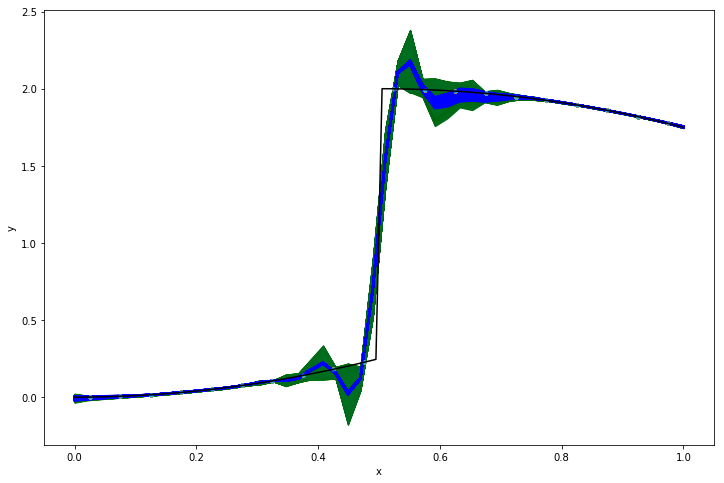

In [19]:
mini = 150
maxi = 400
plt.figure(figsize=(12, 8))

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var=mean_n_mat[i,:])  
plt.plot(X_true, Y_true, 'k')

In [16]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [17]:
mini = 100
maxi = 200
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

NameError: name 'MeanL' is not defined

In [ ]:
m.predict_f_samples(xx, 100).shape